<a href="https://colab.research.google.com/github/Anjalichimnani/EVA4/blob/master/Assignment_5/EVA4_MNIST_Fourth_Step_Adding_GAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture Insights:

**Target**: To Enable flexibility in model algorithm for the output layer by introducing GAP (Global Average Pooling) layer

**Result**: 
  Parameters: 6,800
  Epochs: 14
  Maximum Train Accuracy: 96.92
  Maximum Test Accuracy: 98.34

**Analysis**: Reduced Number of parameters as the final layer involved depending on the previous big kernel was reduced to a nearly constant layer, w.r.t computation and parameters.

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,out_channels = 5, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=5),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#26

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels = 10,out_channels = 15, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=15),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#22

        #Transition Block 1
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels = 15, out_channels = 5, kernel_size = (1, 1), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=5),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#11

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#9
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 15, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=15),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#7

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels = 15,out_channels = 20, kernel_size = (3, 3), padding = 0, bias = False),    
            nn.BatchNorm2d(num_features=20),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#5
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels = 20,out_channels = 10, kernel_size = (1, 1), padding = 0, bias = False),    
            nn.BatchNorm2d(num_features=10),
            nn.Dropout(p = 0.1),
            nn.ReLU()
        )#3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
!pip install tqdm -U

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              45
       BatchNorm2d-2            [-1, 5, 26, 26]              10
           Dropout-3            [-1, 5, 26, 26]               0
              ReLU-4            [-1, 5, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             450
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
      BatchNorm2d-10           [-1, 15, 22, 22]              30
          Dropout-11           [-1, 15, 22, 22]               0
             ReLU-12           [-1, 15, 22, 22]               0
        Ma

In [0]:
from tqdm.notebook import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx}')
    train_acc.append(100*correct/processed)

  print ('\n\nTrain Set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss, correct, processed, 100. * correct/processed
    ))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0





Train Set: Average Loss: 0.2293, Accuracy: 51563/60000 (85.94%)


Test set: Average loss: 0.1548, Accuracy: 9569/10000 (95.69%)

EPOCH: 1





Train Set: Average Loss: 0.0853, Accuracy: 57258/60000 (95.43%)


Test set: Average loss: 0.1137, Accuracy: 9698/10000 (96.98%)

EPOCH: 2





Train Set: Average Loss: 0.1586, Accuracy: 57687/60000 (96.14%)


Test set: Average loss: 0.0917, Accuracy: 9716/10000 (97.16%)

EPOCH: 3





Train Set: Average Loss: 0.1449, Accuracy: 57960/60000 (96.60%)


Test set: Average loss: 0.0648, Accuracy: 9809/10000 (98.09%)

EPOCH: 4





Train Set: Average Loss: 0.1217, Accuracy: 58150/60000 (96.92%)


Test set: Average loss: 0.0534, Accuracy: 9834/10000 (98.34%)

EPOCH: 5





Train Set: Average Loss: 0.1314, Accuracy: 58245/60000 (97.08%)


Test set: Average loss: 0.0504, Accuracy: 9848/10000 (98.48%)

EPOCH: 6





Train Set: Average Loss: 0.0851, Accuracy: 58293/60000 (97.16%)


Test set: Average loss: 0.0499, Accuracy: 9859/10000 (98.59%)

EPOCH: 7





Train Set: Average Loss: 0.1302, Accuracy: 58390/60000 (97.32%)


Test set: Average loss: 0.0490, Accuracy: 9861/10000 (98.61%)

EPOCH: 8





Train Set: Average Loss: 0.1087, Accuracy: 58458/60000 (97.43%)


Test set: Average loss: 0.0472, Accuracy: 9859/10000 (98.59%)

EPOCH: 9





Train Set: Average Loss: 0.0286, Accuracy: 58430/60000 (97.38%)


Test set: Average loss: 0.0505, Accuracy: 9836/10000 (98.36%)

EPOCH: 10





Train Set: Average Loss: 0.1196, Accuracy: 58518/60000 (97.53%)


Test set: Average loss: 0.0421, Accuracy: 9873/10000 (98.73%)

EPOCH: 11





Train Set: Average Loss: 0.1495, Accuracy: 58482/60000 (97.47%)


Test set: Average loss: 0.0462, Accuracy: 9865/10000 (98.65%)

EPOCH: 12





Train Set: Average Loss: 0.0315, Accuracy: 58565/60000 (97.61%)


Test set: Average loss: 0.0413, Accuracy: 9872/10000 (98.72%)

EPOCH: 13





Train Set: Average Loss: 0.1509, Accuracy: 58557/60000 (97.59%)


Test set: Average loss: 0.0389, Accuracy: 9888/10000 (98.88%)

EPOCH: 14





Train Set: Average Loss: 0.1659, Accuracy: 58647/60000 (97.75%)


Test set: Average loss: 0.0423, Accuracy: 9868/10000 (98.68%)



Text(0.5, 1.0, 'Test Accuracy')

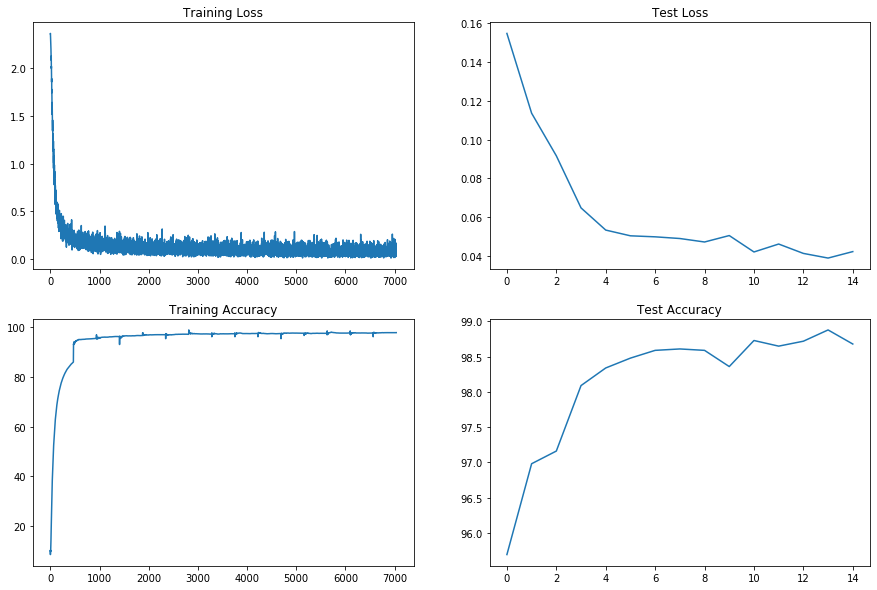

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")